# Mentions

## Data prep

### Load the data and count.

In [1]:
import pandas as pd
import numpy as np
import logging
from dateutil.parser import parse as date_parse
from utils import load_tweet_df, tweet_type

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Simply the tweet on load
def mention_transform(tweet):
    mentions = []
    if 'retweeted_status' not in tweet and 'quoted_status' not in tweet:
        for mention in tweet.get('entities', {}).get('user_mentions', []):
            mentions.append({
                'tweet_id': tweet['id_str'],
                'user_id': tweet['user']['id_str'],
                'screen_name': tweet['user']['screen_name'],
                'mention_user_id': mention['id_str'],
                'mention_screen_name': mention['screen_name'],
                'tweet_created_at': date_parse(tweet['created_at'])
            })
    return mentions

mention_df = load_tweet_df(mention_transform, ['tweet_id', 'user_id', 'screen_name', 'mention_user_id',
                                           'mention_screen_name', 'tweet_created_at'])

INFO:root:Loading from tweets/5936930d07c44a1fb22378ef93e07035_001.json.gz
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
INFO:root:Loading from tweets/929612cdd2594269a16b590888a17447_001.json.gz
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
INFO:root:Loading from tweets/adda61cb31f044ffafecacc6331b0e7d_001.json.gz
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
DEBUG:root:Loaded 450000


### Number of mentions found in the dataset

In [2]:
mention_df[['mention_user_id']].count()

mention_user_id    113355
dtype: int64

### The mention data
Each mention consists of the tweet id, the screen name and user id that is mentioned,
and the screen_name and user_id that is mentioning.

In [3]:
mention_df.head()

,tweet_id,user_id,screen_name,mention_user_id,mention_screen_name,tweet_created_at
1,874695069584027648,15731368,HowardKurtz,171154131,HappeningNow,2017-06-13 18:28:50+00:00
2,874652287809064960,15731368,HowardKurtz,110445334,megynkelly,2017-06-13 15:38:50+00:00
3,874281339150884864,15731368,HowardKurtz,486907980,CarleyShimkus,2017-06-12 15:04:49+00:00
6,874265555552882688,15731368,HowardKurtz,228747444,TheJuanWilliams,2017-06-12 14:02:06+00:00
8,873968413160464384,15731368,HowardKurtz,3056746427,JessicaTarlov,2017-06-11 18:21:21+00:00


### Create lookup of mentioned user ids to screen names

In [4]:
# From the mentions, extract map of user ids to screen names
mention_user_id_lookup_df = mention_df.loc[mention_df.groupby('mention_user_id')['tweet_created_at'].idxmax()].ix[:,['mention_user_id', 'mention_screen_name']].set_index(['mention_user_id'])
mention_user_id_lookup_df.count()

mention_screen_name    25644
dtype: int64

In [5]:
mention_user_id_lookup_df.head()

,mention_screen_name
mention_user_id,
100005598,hotelkeys
10003742,hari
100039156,briancassella
1000968684,bmcushing
100136358,Karnythia


### Create lookup of user ids to screen names

In [6]:
# From the users (not the mentions), extract map of user ids to screen names
user_id_lookup_df = mention_df.loc[mention_df.groupby('user_id')['tweet_created_at'].idxmax()].ix[:,['user_id', 'screen_name']].set_index(['user_id'])
user_id_lookup_df.count()

screen_name    2056
dtype: int64

### Group mentions by mentioned user id

In [7]:
# Group by user_id
# This count should match the user_id map count
mention_summary_user_id_df = pd.DataFrame(mention_df.groupby('mention_user_id').size(), columns=['mention_count'])
mention_summary_user_id_df.count()

mention_count    25644
dtype: int64

In [8]:
mention_summary_user_id_df.head()

,mention_count
mention_user_id,
100005598,2
10003742,4
100039156,1
1000968684,1
100136358,4


### Add back in the mention screen names

In [9]:
# Join with user id map
mention_summary_screen_name_df = mention_summary_user_id_df.join(mention_user_id_lookup_df)
mention_summary_screen_name_df.count()

mention_count          25644
mention_screen_name    25644
dtype: int64

In [10]:
mention_summary_screen_name_df.head()

,mention_count,mention_screen_name
mention_user_id,,
100005598,2,hotelkeys
10003742,4,hari
100039156,1,briancassella
1000968684,1,bmcushing
100136358,4,Karnythia


### Add users types for mentions

In [11]:
# Load lookups of known users
from utils import load_user_type_lookup_df

user_type_lookup_df = load_user_type_lookup_df()[['type']]
user_type_lookup_df.count()

INFO:root:Loading lookups from lookups/senate_press_lookup.csv
INFO:root:Loading lookups from lookups/periodical_press_lookup.csv
INFO:root:Loading lookups from lookups/radio_and_television_lookup.csv


type    2493
dtype: int64

In [12]:
user_type_lookup_df.head()

,type
user_id,
23455653,beltway_journalists
33919343,beltway_journalists
18580432,beltway_journalists
399225358,beltway_journalists
18834692,beltway_journalists


In [13]:
user_type_lookup_df['type'].value_counts()

beltway_journalists    2493
Name: type, dtype: int64

In [14]:
# Join the mentions and the known users
mention_summary_type_df = mention_summary_screen_name_df.join(user_type_lookup_df, how='left')
mention_summary_type_df['type'].fillna('unknown', inplace=True)
mention_summary_type_df.index.name = 'user_id'
mention_summary_type_df.count()

mention_count          25644
mention_screen_name    25644
type                   25644
dtype: int64

In [15]:
mention_summary_type_df.head()

,mention_count,mention_screen_name,type
user_id,,,
100005598,2,hotelkeys,unknown
10003742,4,hari,unknown
100039156,1,briancassella,unknown
1000968684,1,bmcushing,unknown
100136358,4,Karnythia,unknown


### Add number of users mentioning
Which is different than the number of mentions.

In [16]:
mention_user_id_per_user_df = mention_df[['mention_user_id', 'user_id']].drop_duplicates()
mention_user_id_per_user_summary_df = pd.DataFrame(mention_user_id_per_user_df.groupby('mention_user_id').size(), columns=['users_mentioning_count'])
mention_user_id_per_user_summary_df.index.name = 'user_id'
mention_user_id_per_user_summary_df.head()
# Join with mention_summary_type_df
mention_summary_df = mention_summary_type_df.join(mention_user_id_per_user_summary_df)
mention_summary_df['percent_of_users_mentioning'] = mention_summary_df.users_mentioning_count / user_id_lookup_df['screen_name'].count()
mention_summary_df.head()


,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
100005598,2,hotelkeys,unknown,2,0.000973
10003742,4,hari,unknown,3,0.001459
100039156,1,briancassella,unknown,1,0.000486
1000968684,1,bmcushing,unknown,1,0.000486
100136358,4,Karnythia,unknown,1,0.000486


## Mention summary

### Mentions per user
For users that made any mentions. Also to possible to figure this out for all users.

In [17]:
mention_df['user_id'].value_counts().describe()

count    2056.000000
mean       55.133755
std       145.858953
min         1.000000
25%         6.000000
50%        18.000000
75%        58.000000
max      4778.000000
Name: user_id, dtype: float64

### How long is the tail?

In [18]:
mention_grouped_by_users_mentioning_df = mention_summary_df[['mention_count', 'users_mentioning_count']].groupby(by='users_mentioning_count').agg([np.sum, np.size])
mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum'] = mention_grouped_by_users_mentioning_df['mention_count', 'sum'].cumsum()
mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum_percentage'] = mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum'] / mention_grouped_by_users_mentioning_df['mention_count', 'sum'].sum()
mention_grouped_by_users_mentioning_df['cumulative_mentioned_users'] = mention_grouped_by_users_mentioning_df['mention_count', 'size'].cumsum()
mention_grouped_by_users_mentioning_df['cumulative_mentioned_users_percentage'] = mention_grouped_by_users_mentioning_df['cumulative_mentioned_users'] / mention_grouped_by_users_mentioning_df['mention_count', 'size'].sum()
mention_grouped_by_users_mentioning_df

mention_count        cumulative_mention_count_sum  \
                                 sum   size                                
users_mentioning_count                                                     
1                              31346  19101                        31346   
2                               9905   2898                        41251   
3                               5803   1087                        47054   
4                               4690    600                        51744   
5                               4402    429                        56146   
6                               3169    264                        59315   
7                               2396    194                        61711   
8                               2159    147                        63870   
9                               1782    109                        65652   
10                              2055    106                        67707   
11                              1854     92                        69561   
12                              1349     50                        70910   
13                              1633     60                        72543   
14                              1518     52                        74061   
15                              1359     44                        75420   
16                              1069     34                        76489   
17                              1516     40                        78005   
18                               810     27                        78815   
19                              1246     27                        80061   
20                               421     12                        80482   
21                              1126     24                        81608   
22                               702     15                        82310   
23                               941     19                        83251   
24                              1197     17                        84448   
25                               595     10                        85043   
26                               977     15                        86020   
27                               642     11                        86662   
28                               782     15                        87444   
29                              1082     12                        88526   
30                               536      9                        89062   
...                              ...    ...                          ...   
53                               120      1                        99921   
55                               204      1                       100125   
56                               396      3                       100521   
57                               210      2                       100731   
58                               450      3                       101181   
59                               273      1                       101454   
60                               101      1                       101555   
61                                98      1                       101653   
62                               281      2                       101934   
64                               102      1                       102036   
67                               324      1                       102360   
68                               153      1                       102513   
70                               527      3                       103040   
72                               399      1                       103439   
74                               232      1                       103671   
79                               319      1                       103990   
82                               394      2                       104384   
83                               956      2                       105340   
86                               211      1                       10555

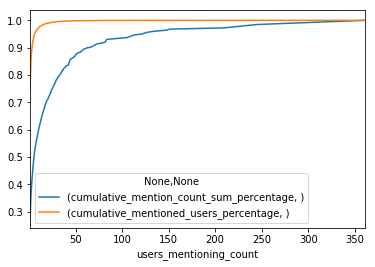

In [19]:
%matplotlib inline
mention_grouped_by_users_mentioning_df[['cumulative_mention_count_sum_percentage', 'cumulative_mentioned_users_percentage']].plot()

## Cut off the tail.
Removes users that were only mentioned by 1 user.

In [20]:
mention_summary_df.drop(mention_summary_df[mention_summary_df.users_mentioning_count == 1].index, inplace=True)
mention_summary_df['mention_screen_name'].count()

6543

## Approach 1: By mention count

### Top accounts (by mention count)
Unknown for type indicates that it is not matched with an known Twitter account.

In [21]:
mention_summary_df.sort_values('mention_count', ascending=False).head(50)

,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
25073877,1730,realDonaldTrump,unknown,361,0.175584
822215679726100480,1407,POTUS,unknown,245,0.119163
51241574,1113,AP,unknown,113,0.054961
15391102,1009,wusa9,unknown,44,0.021401
14980820,845,nbcwashington,unknown,43,0.020914
15754281,775,USATODAY,unknown,83,0.040370
18956073,661,dcexaminer,unknown,50,0.024319
3108351,629,WSJ,unknown,105,0.051070
807095,515,nytimes,unknown,209,0.101654


### Account types (by mention count)

In [22]:
types_by_mention_count_df = mention_summary_df[['type', 'mention_count']].groupby('type').sum()
types_by_mention_count_df['type_percentage']= types_by_mention_count_df['mention_count'] / types_by_mention_count_df['mention_count'].sum()
types_by_mention_count_df.sort_values('mention_count', ascending=False)

,mention_count,type_percentage
type,,
unknown,67652,0.824934
beltway_journalists,14357,0.175066


## Approach 2: Per user
Mentions by type per user.

### Add type by merging screen name lookup

In [23]:
mention_all_join_df = pd.merge(mention_df, user_type_lookup_df[['type']], how='left', left_on='mention_user_id', right_index=True)
mention_all_join_df['type'].fillna('unknown', inplace=True)
# Drop tail
mention_all_join_limited_df = mention_all_join_df[mention_all_join_df.mention_user_id.isin(mention_summary_df.index)]
mention_all_join_limited_df.head()

,tweet_id,user_id,screen_name,mention_user_id,mention_screen_name,tweet_created_at,type
1,874695069584027648,15731368,HowardKurtz,171154131,HappeningNow,2017-06-13 18:28:50+00:00,unknown
2,874652287809064960,15731368,HowardKurtz,110445334,megynkelly,2017-06-13 15:38:50+00:00,unknown
6,874265555552882688,15731368,HowardKurtz,228747444,TheJuanWilliams,2017-06-12 14:02:06+00:00,unknown
8,873968413160464384,15731368,HowardKurtz,3056746427,JessicaTarlov,2017-06-11 18:21:21+00:00,unknown
9,873955901484486656,15731368,HowardKurtz,16157855,edhenry,2017-06-11 17:31:38+00:00,beltway_journalists


In [24]:
mention_summary_by_user_df = mention_all_join_limited_df.groupby([mention_all_join_limited_df.user_id, mention_all_join_limited_df.type]).size().unstack().fillna(0)
# Add a total column
mention_summary_by_user_df['total'] = mention_summary_by_user_df.sum(axis=1)
for col_name in mention_summary_by_user_df.columns[:-1]:
    mention_summary_by_user_df['{}_percent'.format(col_name)] = mention_summary_by_user_df[col_name] / mention_summary_by_user_df.total
mention_summary_by_user_df.head(10)

type,beltway_journalists,unknown,total,beltway_journalists_percent,unknown_percent
user_id,,,,,
1001991865,0.0,1.0,1.0,0.000000,1.000000
1002229862,2.0,12.0,14.0,0.142857,0.857143
100802089,0.0,3.0,3.0,0.000000,1.000000
100860790,7.0,22.0,29.0,0.241379,0.758621
1009749229,5.0,21.0,26.0,0.192308,0.807692
1013785220,2.0,11.0,13.0,0.153846,0.846154
10162772,2.0,48.0,50.0,0.040000,0.960000
102171691,29.0,266.0,295.0,0.098305,0.901695
1025521,13.0,43.0,56.0,0.232143,0.767857


### Average of percent of mentions by type for each user
That is, for each user determine the percent of mentions by type. Then take the average of each type.

Thus, this mention analysis is on a per-user basis, accounting for how prolific a tweeter a user is. (That is, users who tweet aren't weighed more heavily.)


In [25]:
mention_summary_by_user_df.filter(axis=1, regex="_percent$").mean()

type
beltway_journalists_percent    0.170117
unknown_percent                0.829883
dtype: float64

## Approach 3: By count of users mentioning
The number of users that mentioned an account. Thus, each user counts as 1, even if that user made multiple mentions of the account.

This weights an account that is mentioned by a 100 users more heavily than an account that is mentioned a 100 times by a single user.

In [26]:
mention_summary_df.sort_values('users_mentioning_count', ascending=False).head(20)

,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
25073877,1730,realDonaldTrump,unknown,361,0.175584
822215679726100480,1407,POTUS,unknown,245,0.119163
807095,515,nytimes,unknown,209,0.101654
759251,420,CNN,unknown,151,0.073444
9300262,471,politico,unknown,148,0.071984
2467791,351,washingtonpost,unknown,134,0.065175
818927131883356161,426,PressSec,unknown,128,0.062257
1209417007,392,SteveScalise,unknown,124,0.060311
18916432,350,SpeakerRyan,unknown,121,0.058852


### Account types (by count of users mentioning)

In [27]:
types_by_users_mentioning_df = mention_summary_df[['type', 'users_mentioning_count']].groupby('type').sum()
types_by_users_mentioning_df['type_percentage']= types_by_users_mentioning_df['users_mentioning_count'] / types_by_users_mentioning_df['users_mentioning_count'].sum()
types_by_users_mentioning_df.sort_values('users_mentioning_count', ascending=False)

,users_mentioning_count,type_percentage
type,,
unknown,29124,0.793699
beltway_journalists,7570,0.206301


## Known / Unknown accounts
Remember, the tail has been cut off

### Known accounts

In [28]:
 mention_summary_df[mention_summary_df.type != 'unknown'].count()

mention_count                  959
mention_screen_name            959
type                           959
users_mentioning_count         959
percent_of_users_mentioning    959
dtype: int64

### Unknown accounts

In [29]:
not_known_mention_df = mention_summary_df[mention_summary_df.type == 'unknown']
not_known_mention_df.count()

mention_count                  5584
mention_screen_name            5584
type                           5584
users_mentioning_count         5584
percent_of_users_mentioning    5584
dtype: int64

In [30]:
not_known_mention_sorted_df = not_known_mention_df.sort_values('mention_count', ascending=False)[['mention_screen_name', 'mention_count', 'users_mentioning_count']]
not_known_mention_sorted_df.head(20)

,mention_screen_name,mention_count,users_mentioning_count
user_id,,,
25073877,realDonaldTrump,1730,361
822215679726100480,POTUS,1407,245
51241574,AP,1113,113
15391102,wusa9,1009,44
14980820,nbcwashington,845,43
15754281,USATODAY,775,83
18956073,dcexaminer,661,50
3108351,WSJ,629,105
807095,nytimes,515,209


### Write unknown accounts to file

In [31]:
not_known_mention_sorted_df.to_csv('output/unknown_mentions.csv')